In [2]:
import os, sys
sys.path.append('../')
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time, datetime
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from datasets import WindowedGaitDataset, ToTensor, ExobootDataset
from gait_transformer import GaitTransformer
from save_best_model import SaveBestModel
from training_utils import phase_dist, unscale_kinematics, unscale_gait_state
from torch_training_utils import GaitLoss, EWC, enum_parameters


import random
# Set the seed value all over the place to make this reproducible.
seed_val = 42


random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

#RUN THIS ON COLAB
ON_COLAB = False
if ON_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    drive_path = '/content/drive/MyDrive/Phase ML Data/'

In [3]:
!gsutil cp -r gs://ml_gait_estimation/r01_ordered_stairs_label_corrupt_time.csv .
!gsutil cp -r gs://ml_gait_estimation/r01_randomized_stairs_label_corrupt_time.csv .
!gsutil cp -r gs://ml_gait_estimation/dataport_ordered_stairs_label_corrupt_time.csv .
!gsutil cp -r gs://ml_gait_estimation/dataport_randomized_stairs_label_corrupt_time.csv .
!gsutil cp -r gs://ml_gait_estimation/gt_ordered_stairs_label_corrupt_time.csv .
!gsutil cp -r gs://ml_gait_estimation/gt_randomized_stairs_label_corrupt_time.csv .

Copying gs://ml_gait_estimation/r01_ordered_stairs_label_corrupt_time.csv...
\ [1 files][303.9 MiB/303.9 MiB]                                                
Operation completed over 1 objects/303.9 MiB.                                    
Copying gs://ml_gait_estimation/r01_randomized_stairs_label_corrupt_time.csv...
\ [1 files][304.1 MiB/304.1 MiB]                                                
Operation completed over 1 objects/304.1 MiB.                                    
Copying gs://ml_gait_estimation/dataport_ordered_stairs_label_corrupt_time.csv...
| [1 files][506.4 MiB/506.4 MiB]                                                
Operation completed over 1 objects/506.4 MiB.                                    
Copying gs://ml_gait_estimation/dataport_randomized_stairs_label_corrupt_time.csv...
| [1 files][507.1 MiB/507.1 MiB]                                                
Operation completed over 1 objects/507.1 MiB.                                    
Copying gs://ml_gait_est

In [4]:
window_size = 150 #set the number of kinematics in the buffer to the transformer

#set up kinematics scaling
meas_scale = np.array([[-69.35951035,  27.62815047],\
                        [-456.18013759,  401.13782617],\
                        [-63.71649984,  22.06632622],\
                        [-213.4786175,   396.93801619],\
                        [-35.26603985,  20.78473636],\
                        [-20.95456523,  14.63961137],\
                          [0,1]])

#set up gait state scaling
speed_scale = (0,2)
incline_scale = (-10,10)
stair_height_scale = (-1,1)

#set up filenames for each data file
filename_dataport_ordered = 'dataport_ordered_stairs_label_corrupt_time.csv'
filename_dataport_randomized = 'dataport_randomized_stairs_label_corrupt_time.csv'

filename_r01_ordered = 'r01_ordered_stairs_label_corrupt_time.csv'
filename_r01_randomized = 'r01_randomized_stairs_label_corrupt_time.csv'

filename_gt_ordered = 'gt_ordered_stairs_label_corrupt_time.csv'
filename_gt_randomized = 'gt_randomized_stairs_label_corrupt_time.csv'

if ON_COLAB:
    filename_r01_ordered = drive_path+filename_r01_ordered
    filename_r01_randomized = drive_path+filename_r01_randomized
    filename_dataport_ordered = drive_path+filename_dataport_ordered
    filename_dataport_randomized = drive_path+filename_dataport_randomized
    filename_gt_ordered = drive_path+filename_gt_ordered
    filename_gt_randomized = drive_path+filename_gt_randomized
    

DO_DECIMATION = not True
if DO_DECIMATION:
    gait_data_r01_randomized = pd.read_csv(filename_r01_randomized, nrows=10000)
    gait_data_r01_ordered = pd.read_csv(filename_r01_ordered, nrows=10000)
    gait_data_dataport_ordered = pd.read_csv(filename_dataport_ordered, nrows=10000)
    gait_data_dataport_randomized = pd.read_csv(filename_dataport_randomized, nrows=10000)
    gait_data_gt_ordered = pd.read_csv(filename_gt_ordered, nrows=10000)
    gait_data_gt_randomized = pd.read_csv(filename_gt_randomized, nrows=10000)

    
else:
    gait_data_r01_randomized = pd.read_csv(filename_r01_randomized)
    gait_data_r01_ordered = pd.read_csv(filename_r01_ordered)
    gait_data_dataport_ordered = pd.read_csv(filename_dataport_ordered)
    gait_data_dataport_randomized = pd.read_csv(filename_dataport_randomized)
    gait_data_gt_ordered = pd.read_csv(filename_gt_ordered)
    gait_data_gt_randomized = pd.read_csv(filename_gt_randomized)


# REMOVE RANDOM SUBJECTS FOR X-VALIDATION
#FROM R01, remove two: AB02 and AB06
#FROM DATAPORT, remove three: AB09, AB05, and AB10
#FROM GT, remove six, AB25, AB28, AB30, AB20, AB12, AB09
REMOVE_SUBS_XVAL = True

if REMOVE_SUBS_XVAL:
    #r01 ordered
    index_sub_remove_r01 = gait_data_r01_ordered[ (gait_data_r01_ordered['subj_id'] == 2) | (gait_data_r01_ordered['subj_id'] == 6) ].index
    gait_data_r01_ordered_val = gait_data_r01_ordered.iloc[index_sub_remove_r01]
    gait_data_r01_ordered.drop(index_sub_remove_r01 , inplace=True)
    
    #r01 randomized
    index_sub_remove_r01 = gait_data_r01_randomized[ (gait_data_r01_randomized['subj_id'] == 2) | (gait_data_r01_randomized['subj_id'] == 6) ].index
    gait_data_r01_randomized_val = gait_data_r01_randomized.iloc[index_sub_remove_r01]
    gait_data_r01_randomized.drop(index_sub_remove_r01 , inplace=True)
    
    print(gait_data_r01_ordered.head())
    print(gait_data_r01_ordered_val.head())
    
    #dataport ordered
    index_sub_remove_dataport = gait_data_dataport_ordered[ (gait_data_dataport_ordered['subj_id'] == 9) | 
                                                           (gait_data_dataport_ordered['subj_id'] == 5) |
                                                          (gait_data_dataport_ordered['subj_id'] == 10)].index

    gait_data_dataport_ordered_val = gait_data_dataport_ordered.iloc[index_sub_remove_dataport]
    gait_data_dataport_ordered.drop(index_sub_remove_dataport , inplace=True)
    
    #dataport randomized
    index_sub_remove_dataport = gait_data_dataport_randomized[ (gait_data_dataport_randomized['subj_id'] == 9) | 
                                                           (gait_data_dataport_randomized['subj_id'] == 5) |
                                                          (gait_data_dataport_randomized['subj_id'] == 10)].index

    gait_data_dataport_randomized_val = gait_data_dataport_randomized.iloc[index_sub_remove_dataport]
    gait_data_dataport_randomized.drop(index_sub_remove_dataport , inplace=True)
    
    #gt ordered
    index_sub_remove_gt = gait_data_gt_ordered[ (gait_data_gt_ordered['subj_id'] == 25) | 
                                               (gait_data_gt_ordered['subj_id'] == 28) |
                                              (gait_data_gt_ordered['subj_id'] == 30) |
                                              (gait_data_gt_ordered['subj_id'] == 20) |
                                              (gait_data_gt_ordered['subj_id'] == 12) |
                                              (gait_data_gt_ordered['subj_id'] == 9)].index
    
    gait_data_gt_ordered_val = gait_data_gt_ordered.iloc[index_sub_remove_gt]
    gait_data_gt_ordered.drop(index_sub_remove_gt , inplace=True)
    
    #gt randomized
    index_sub_remove_gt = gait_data_gt_randomized[ (gait_data_gt_randomized['subj_id'] == 25) | 
                                               (gait_data_gt_randomized['subj_id'] == 28) |
                                              (gait_data_gt_randomized['subj_id'] == 30) |
                                              (gait_data_gt_randomized['subj_id'] == 20) |
                                              (gait_data_gt_randomized['subj_id'] == 12) |
                                              (gait_data_gt_randomized['subj_id'] == 9)].index
    
    gait_data_gt_randomized_val = gait_data_gt_randomized.iloc[index_sub_remove_gt]
    gait_data_gt_randomized.drop(index_sub_remove_gt , inplace=True)
    
    #concatenate
    gait_data = pd.concat([gait_data_r01_ordered, gait_data_r01_randomized,\
                          gait_data_dataport_ordered, gait_data_dataport_randomized,\
                          gait_data_gt_ordered, gait_data_gt_randomized])
    
    gait_data_val = pd.concat([gait_data_r01_ordered_val, gait_data_r01_randomized_val,\
                              gait_data_dataport_ordered_val, gait_data_dataport_randomized_val,\
                              gait_data_gt_ordered_val, gait_data_gt_randomized_val])
    
    train_dataset = WindowedGaitDataset(gait_data=gait_data,
                                                meas_scale=meas_scale,
                                                window_size = window_size,
                                                speed_scale = speed_scale,
                                                incline_scale = incline_scale,
                                                stair_height_scale=stair_height_scale,
                                                transform=ToTensor())
    
    val_dataset = WindowedGaitDataset(gait_data=gait_data_val,
                                                meas_scale=meas_scale,
                                                window_size = window_size,
                                                speed_scale = speed_scale,
                                                incline_scale = incline_scale,
                                                stair_height_scale=stair_height_scale,
                                                transform=ToTensor())
    
    print('{:>5,} training samples'.format(len(train_dataset)))
    print('{:>5,} validation samples'.format(len(val_dataset)))


else:
    gait_data = pd.concat([gait_data_r01_ordered, gait_data_r01_randomized,\
                          gait_data_dataport_ordered, gait_data_dataport_randomized,\
                          gait_data_gt_ordered, gait_data_gt_randomized])
    # gait_data = gait_data_r01_randomized
    # gait_data = pd.concat([gait_data_r01_randomized, gait_data_dataport_randomized])
    
    dataset = WindowedGaitDataset(gait_data=gait_data,
                                            meas_scale=meas_scale,
                                            window_size = window_size,
                                            speed_scale = speed_scale,
                                            incline_scale = incline_scale,
                                            stair_height_scale=stair_height_scale,
                                            transform=ToTensor())  
    # Create a 90-10 train-validation split.

    # Calculate the number of samples to include in each set.
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size


    # Divide the dataset by randomly selecting samples.
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    print('{:>5,} training samples'.format(train_size))
    print('{:>5,} validation samples'.format(val_size))

print(val_dataset[0]['meas'][-1,:])
print(val_dataset[1]['meas'][-1,:])
print(val_dataset[2]['meas'][-1,:])






   foot_angle  foot_vel_angle  shank_angle  shank_vel_angle  heel_acc_forward  \
0    9.713109     -122.000000     6.810365       -54.155000          0.000000   
1    7.928249     -133.739183     5.993880       -61.785706         -3.391320   
2    7.120444     -147.077747     5.606053       -70.516308         -7.078094   
3    5.217823     -162.450106     4.621966       -84.205665         -3.548601   
4    3.440199     -167.100286     3.626258       -93.718654         -1.555049   

   heel_acc_upward     phase  speed  incline  stair_height  is_moving  \
0         0.000000  0.000968    0.8    -10.0           0.0        1.0   
1         2.057084  0.013282    0.8    -10.0           0.0        1.0   
2         4.304541  0.018221    0.8    -10.0           0.0        1.0   
3         2.657375  0.028783    0.8    -10.0           0.0        1.0   
4         1.422208  0.038366    0.8    -10.0           0.0        1.0   

   stride_count  HSDetected  subj_id        dt      time  
0             1

In [16]:
#Load model
test_dataset = val_dataset

BATCH_SIZE = 1024*4
prediction_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False,num_workers=8)
# Prediction on test set

print('Predicting labels for {:,} test points...'.format(len(test_dataset)))

# Model parameters
dim_val = 32 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 4 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_encoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
n_decoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
input_size = 7 # The number of input variables. 1 if univariate forecasting.
enc_seq_len = 150 # length of input given to encoder. Can have any integer value.
dec_seq_len = 1 # length of input given to decoder. Can have any integer value.

dropout_encoder = 0.1
dropout_decoder = 0.1
dropout_pos_enc = 0.0
dropout_regression = 0.1
dim_feedforward_encoder = 512
dim_feedforward_decoder = 512

num_predicted_features = 5 # The number of output variables. 

best_model = GaitTransformer(
    dim_val=dim_val,
    input_size=input_size, 
    n_encoder_layers=n_encoder_layers,
    n_decoder_layers=n_decoder_layers,
    n_heads=n_heads,
    enc_seq_len=enc_seq_len,
    dropout_encoder=dropout_encoder,
    dropout_decoder=dropout_decoder,
    dropout_pos_enc=dropout_pos_enc,
    dropout_regression=dropout_regression,
    num_predicted_features=num_predicted_features,
    dim_feedforward_encoder=dim_feedforward_encoder,
    dim_feedforward_decoder=dim_feedforward_decoder,
)

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")


best_model.to(device)

model_nickname = 'apollyon-three-stairs'

model_dir = f'../full_models/{model_nickname}/model_save/'
if REMOVE_SUBS_XVAL:
    model_dir = f'../full_models/{model_nickname}/model_save_xval/'
    

checkpoint = torch.load(model_dir+'ml_gait_estimator_dec_best_model.tar')
g = checkpoint['model_state_dict']
loss = checkpoint['loss']
print(f'Lowest Loss: {loss}')
best_model.load_state_dict(g)


epoch = checkpoint['epoch']

# Put model in evaluation mode
best_model.eval()


#Set up start of sequence token
SOS_token = 100 * torch.ones(1, 1, num_predicted_features).to(device).requires_grad_(False)

#Extract index for time steps
DT_IDX = 6


START_IDX = 7500
N_STEPS = 300

#set up which measurement we want to compute gradients wrt
#by default choose the foot angle
MEAS_IDX = 0

# set up the indices for the gait states
SPEED_IDX = 2
INCLINE_IDX = 3
IS_STAIRS_IDX = 4

#preallocate saliency matrices for the gradients
saliency_foot_angle_phase = np.zeros((window_size, N_STEPS))
saliency_foot_angle_speed = np.zeros((window_size, N_STEPS))
saliency_foot_angle_incline = np.zeros((window_size, N_STEPS))
saliency_foot_angle_is_stairs = np.zeros((window_size, N_STEPS))

predictions_general = []

for i in range(N_STEPS):

    meas = test_dataset[START_IDX+i]['meas'].to(device)
    meas = torch.unsqueeze(meas, dim=0)

    # we need to find the gradient with respect to the input measurement buffer, so we need to call requires_grad_ on it
    meas.requires_grad_()


    # Forward pass through the model
    tgt = SOS_token.to(device)#.repeat(b_state.shape[0], 1, 1)
    dts = meas[:,:,DT_IDX]
    dts = torch.unsqueeze(dts, dim=-1)
    preds = best_model(meas,tgt, dts)


    #store predictions to sanity check
    outputs_general = preds.detach().to('cpu').numpy()
    # print(preds)
    outputs_general = np.squeeze(outputs_general, axis=1)

    #unscale
    outputs_general = unscale_gait_state(outputs_general, speed_scale, incline_scale, stair_height_scale)

    # Store predictions and true labels
    predictions_general.extend(outputs_general.tolist())


    #compute gradients
    #phase
    cp = preds[0,0,0].squeeze().detach().cpu().numpy()
    sp = preds[0,0,1].squeeze().detach().cpu().numpy()

    #compute gradient for cp
    preds[0,0,0].backward(retain_graph=True)
    gradient = meas.grad.data
    gradient_cp = gradient.squeeze().cpu().numpy()
    gradient_cp = gradient_cp[:,MEAS_IDX]

    #compute gradient for sp
    meas.grad.zero_()
    preds[0,0,1].backward(retain_graph=True)
    gradient = meas.grad.data
    gradient_sp = gradient.squeeze().cpu().numpy()
    gradient_sp = gradient_sp[:,MEAS_IDX]

    #combine the gradients for cp and sp to get the gradient for phase (requires trig operations)
    saliency = (1/np.pi) * ((cp/(np.power(cp,2) + np.power(sp,2)))*(gradient_sp) - (sp/(np.power(cp,2) + np.power(sp,2)))*(gradient_cp))
    saliency_foot_angle_phase[:,i] = np.abs(saliency)

    #compute gradients for speed
    meas.grad.zero_()
    preds[0,0,SPEED_IDX].backward(retain_graph=True)

    gradient = meas.grad.data

    saliency = gradient.squeeze().abs().cpu().numpy()
    saliency_foot_angle_speed[:,i] = saliency[:,MEAS_IDX]


    #compute gradients for incline
    meas.grad.zero_()
    preds[0,0,INCLINE_IDX].backward(retain_graph=True)
    gradient = meas.grad.data
    saliency = gradient.squeeze().abs().cpu().numpy()
    saliency_foot_angle_incline[:,i] = saliency[:,MEAS_IDX]

    #compute gradients for is_stairs
    meas.grad.zero_()
    preds[0,0,IS_STAIRS_IDX].backward(retain_graph=True)
    gradient = meas.grad.data
    saliency = gradient.squeeze().abs().cpu().numpy()
    saliency_foot_angle_is_stairs[:,i] = saliency[:,MEAS_IDX]

print('DONE')


  



Predicting labels for 4,477,713 test points...
Using GPU.
Lowest Loss: 0.11826772387912407
DONE


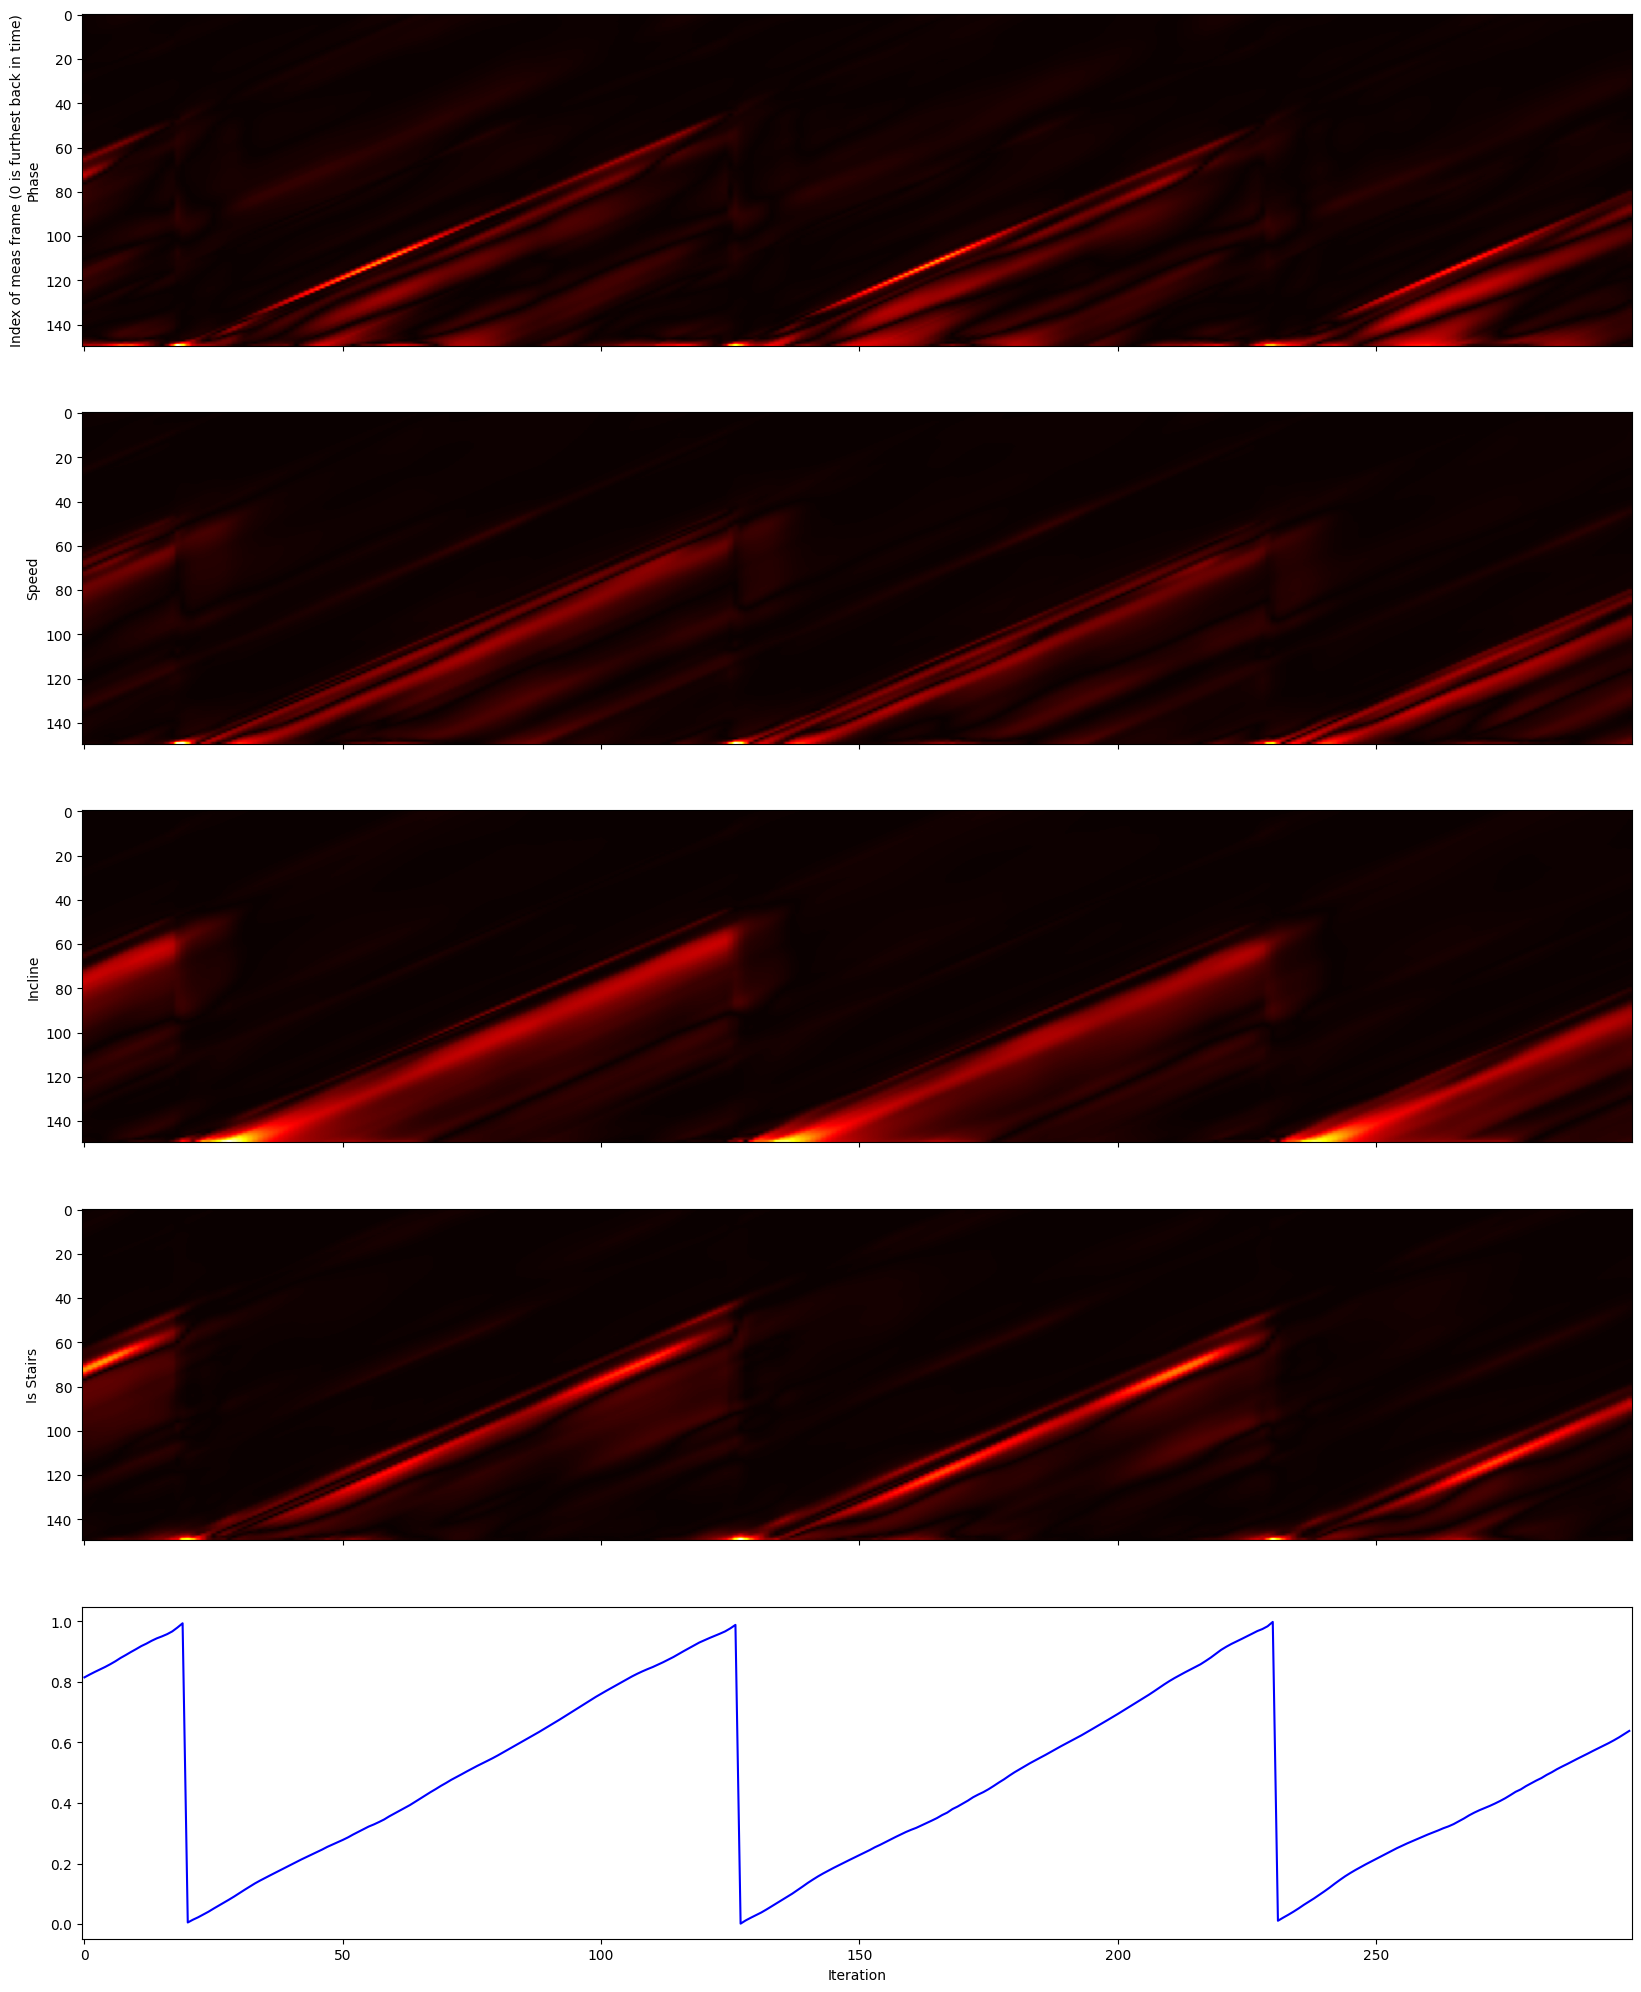

In [22]:
predictions_general = np.array(predictions_general)

# code to plot the saliency map as a heatmap
fig, ax = plt.subplots(5,1,figsize=(20,25),sharex=True)

im = ax[0].imshow(saliency_foot_angle_phase, cmap=plt.cm.hot, origin='upper', aspect="auto")
ax[0].set_ylabel('Index of meas frame (0 is furthest back in time)\nPhase')

im = ax[1].imshow(saliency_foot_angle_speed, cmap=plt.cm.hot, origin='upper', aspect="auto")
# ax.set_yticks(list(range(0,100,10)))
ax[1].set_ylabel('Speed')
# ax[0].plot(predictions_general[:,0],'w',label='predict, general')

im = ax[2].imshow(saliency_foot_angle_incline, cmap=plt.cm.hot, origin='upper', aspect="auto")
ax[2].set_ylabel('Incline')

im = ax[3].imshow(saliency_foot_angle_is_stairs, cmap=plt.cm.hot, origin='upper', aspect="auto")
ax[3].set_ylabel('Is Stairs')

#plot phase
ax[4].plot(predictions_general[:,0],'b',label='predict, general')
ax[4].set_xlabel('Iteration')

plt.show()


#sanity check predictions
DO_PLOT_SANITY_CHECK = not True
if DO_PLOT_SANITY_CHECK:

    fig, axs = plt.subplots(5,1,figsize=(20,20),sharex=True)
    axs[0].plot(predictions_general[:,0],'k--',label='predict, general')
    axs[0].legend()
    axs[0].set_ylabel('Phase')
    # axs[0].set_xlim([80,5000])


    axs[1].plot(predictions_general[:,1],'k--')
    axs[1].set_ylabel('Speed (m/s)')
    axs[1].set_ylim([0,2])


    axs[2].plot(predictions_general[:,2],'k--')
    axs[2].set_ylabel('Incline (deg)')
    # axs[2].set_ylim([-15,15])

    axs[3].plot(predictions_general[:,3],'k--')
    axs[3].set_ylabel('Is Stairs')
    axs[3].set_ylim([-0.2,1.2])


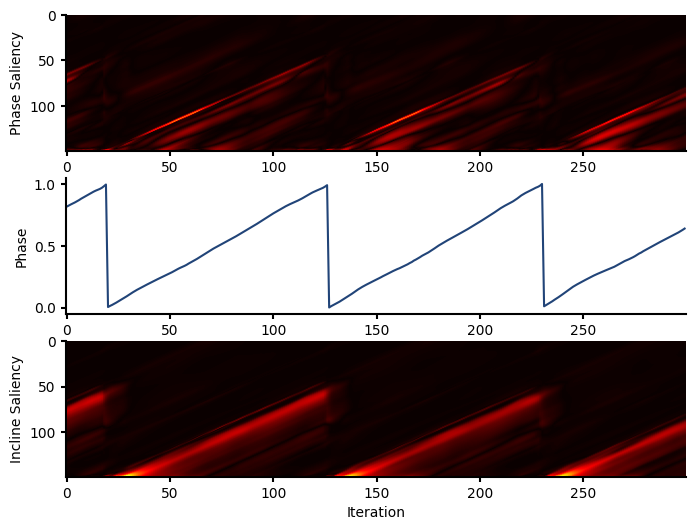

In [40]:
# Plot a fancier figure for the paper
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["mathtext.default"] = "regular"

figWidth = 8
figHeight = 6

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

blueColor = '#214478'

time = np.arange(N_STEPS)/100

predictions_general = np.array(predictions_general)
# code to plot the saliency map as a heatmap
fig, axs = plt.subplots(3,1,figsize=(figWidth,figHeight),sharex=True)

im = axs[0].imshow(saliency_foot_angle_phase, cmap=plt.cm.hot, origin='upper', aspect="auto")
axs[0].set_ylabel('Phase Saliency', fontsize=MEDIUM_SIZE)

axs[1].plot(predictions_general[:,0], color=blueColor, label='predict, general',linewidth=1.5)
axs[1].set_ylabel('Phase', fontsize=MEDIUM_SIZE)


im = axs[2].imshow(saliency_foot_angle_incline, cmap=plt.cm.hot, origin='upper', aspect="auto")
axs[2].set_ylabel('Incline Saliency', fontsize=MEDIUM_SIZE)

axs[-1].set_xlabel('Iteration', fontsize=MEDIUM_SIZE)


for i in range(3):
    ax = axs[i]
    ax.xaxis.set_tick_params(labelsize=MEDIUM_SIZE)
    ax.yaxis.set_tick_params(labelsize=MEDIUM_SIZE)
    ax.xaxis.set_tick_params(width=1.5)
    ax.yaxis.set_tick_params(width=1.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)


    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
        
# for i in range(2):
#     ax = axs[i]
#     ax.set_xticks([])


filename = f'../paper_plotting/saliency_map_raw.png'
plt.savefig(filename, transparent=True,pad_inches=0,bbox_inches='tight', dpi=300)

filename = f'../paper_plotting/saliency_map_raw.svg'
plt.savefig(filename, transparent=True,pad_inches=0,bbox_inches='tight')


plt.show()

